In [2]:
import gym
import numpy as np

# Initialize environment
env = gym.make('CartPole-v0')

K = np.random.rand(4,4)  # State feedback gain, lets show random first so people can see that it is hard
set_point = [0,0,0,0]  # Desired state, v,theta,theta_dot

for episode in range(10):
    state = env.reset()
    done = False
    while not done:
        env.render()
        
        # Compute control input using LQR
        u = -np.dot(K, state - set_point)
        
        # Apply control input (you may need to discretize this)
        action = 0 if u < 0 else 1  # Example discretization
        
        # Step the simulation forward
        state, reward, done, info = env.step(action)
        
env.close()

/Users/rishi/miniconda3/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/rishi/miniconda3/lib/python3.9/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v0", render_mode="rgb_array")
  gym.logger.warn(


TypeError: unsupported operand type(s) for -: 'tuple' and 'list'

## State-Space Representation of the Inverted Pendulum on a Cart

The state-space representation of a system is often expressed in the form \( \dot{x} = Ax + Bu \), where \( x \) is the state vector and \( u \) is the control input. For an inverted pendulum on a cart, the state vector \( x \) consists of:

\[
x = \begin{pmatrix}
    x \\
    \dot{x} \\
    \theta \\
    \dot{\theta}
\end{pmatrix}
\]

- \( x \): Position of the cart
- \( \dot{x} \): Velocity of the cart
- \( \theta \): Angle of the pendulum
- \( \dot{\theta} \): Angular velocity of the pendulum

The control input \( u \) represents the force applied to the cart.

### Equations of Motion

The equations of motion for the inverted pendulum are:

\[
(m_c + m_p) \ddot{x} + m_p l \ddot{\theta} \cos(\theta) - m_p l \dot{\theta}^2 \sin(\theta) = u
\]
\[
l \ddot{\theta} - g \sin(\theta) = - \cos(\theta) \ddot{x}
\]

Where:
- \( m_c \): Mass of the cart
- \( m_p \): Mass of the pendulum
- \( l \): Length of the pendulum
- \( g \): Acceleration due to gravity

### Linearization

For control purposes, these equations are often linearized around the upright position (\( \theta = 0 \), \( \dot{\theta} = 0 \), \( x = 0 \), \( \dot{x} = 0 \)). The linearized system can then be represented as:

\[
A = \begin{pmatrix}
    0 & 1 & 0 & 0 \\
    0 & 0 & -\frac{m_p g}{m_c} & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & \frac{(m_c + m_p) g}{l m_c} & 0
\end{pmatrix}
\]
\[
B = \begin{pmatrix}
    0 \\
    \frac{1}{m_c} \\
    0 \\
    -\frac{1}{l m_c}
\end{pmatrix}
\]

This linearized model provides a good approximation when the system is close to the upright position.

In [20]:
import numpy as np
from scipy.linalg import solve_continuous_are
import control.matlab as c

def lqr_gain(A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    K = np.linalg.inv(R) @ B.T @ P
    return K
mc=5 #kg
mp=1 #kg
g=9.8 #m/s2
l=1 #m
# Define your A, B, Q, and R matrices according to the physics 
A = np.array([[0, 1, 0, 0], [0, 0, -mp*g/mc ,0], [0, 0, 0, 1], [0, 0 ,(mc+mp)*g/(mc*l),0]])  # Replace with your actual A matrix
B = np.array([[0],[1/mc],[0],[-1/(l*mc)]])  # Replace with your actual B matrix
Q = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])  # State weighting matrix
R = np.array([[1]])  # Control weighting matrix

# Compute the LQR gain
#K = lqr_gain(A, B, Q, R)
K, S, E = c.lqr(A, B, Q, R)
sys_cl = c.ss(A - np.matmul(B,K), B, np.eye(4), np.zeros((4, 1)))

<IPython.core.display.Javascript object>


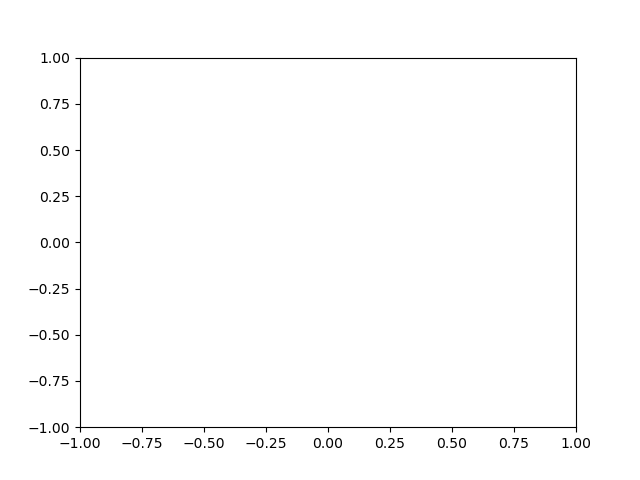

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import odeint
%matplotlib notebook
# Define system dynamics for the closed-loop system
def closed_loop_sys(x, t, A, B, K):
    return np.dot(A - np.dot(B, K), x)

# Given A, B, K matrices
A = np.array([[0, 1, 0, 0], [0, 0, -9.8, 0], [0, 0, 0, 1], [0, 0, 9.8, 0]])
B = np.array([[0], [1], [0], [-1]])
K = np.array([[-0.3162, -1.0443, 14.0671, 3.8304]])

# Initial conditions [x, x_dot, theta, theta_dot]
x0 = np.array([0.1, 0.1, 0.1, 0.1])

# Time grid for integration
t = np.linspace(0, 10, 1000)

# Simulate the closed-loop system
x = odeint(closed_loop_sys, x0, t, args=(A, B, K))

# Extract cart position and pendulum angle
cart_position = x[:, 0]
pendulum_angle = x[:, 2]

# Create animation
fig, ax = plt.subplots()

# Initialize cart and pendulum
cart, = ax.plot([], [], 'bs-', linewidth=5)
pendulum, = ax.plot([], [], 'ro-', linewidth=5)

# Animation initialization function
def init():
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    cart.set_data([], [])
    pendulum.set_data([], [])
    return cart, pendulum

# Animation update function
# Animation update function
def update(i):
    cart_x = cart_position[i]
    pendulum_x = cart_x + np.sin(pendulum_angle[i])
    pendulum_y = -np.cos(pendulum_angle[i])  # Negative because the pendulum hangs down
    
    cart.set_data([cart_x - 0.1, cart_x + 0.1], [0, 0])
    pendulum.set_data([cart_x, pendulum_x], [0, pendulum_y])
    return cart, pendulum

ani = animation.FuncAnimation(fig, update, frames=range(len(t)), init_func=init, blit=True)

plt.show()